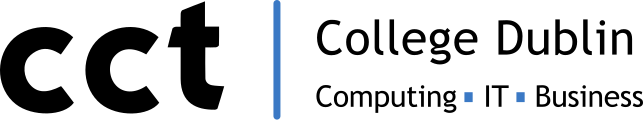

<div style="text-align: center;">
    <h2><u>Capstone Pair Project</u></h2>
    <h3> Problem Solving for Industry</h3>
    <h3>Supervisor: Dr Muhammad Iqbal</h3>
    <h3>Student Names: Danrlei Martins & Leonardo Diesel</h3>
    <h3>Student Numbers: 2020322 & 2020302</h3>
    <h3><a href="https://github.com/danrlei-martins-cct/CCT-Capstone-Project-FER">GitHub Repository</a></h3>
</div>

***

### Install Libraries

In [ ]:
# pip install keras
# pip install tensorflow
# pip install keras_tuner --upgrade
# pip install visualkeras

### Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import keras
import tensorflow as tf
import keras_tuner as kt
import visualkeras
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix

import cv2
from keras.preprocessing import image


## 1. Data Understanding

In [2]:
train_dir = "FER2013/train/" # path with training images
test_dir = "FER2013/test/"   # path with testing images

In [3]:
# Exploring the different expressions (categories) of the FER2013 dataset
train_expressions = os.listdir(train_dir)
test_expressions = os.listdir(test_dir)

print("Expression Categories in Training Images:", train_expressions)
print("Expression Categories in Testing Images:", test_expressions)

Expression Categories in Training Images: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Expression Categories in Testing Images: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Dictionaries to store the image counts
train_image_counts = {expr: 0 for expr in train_expressions}
test_image_counts = {expr: 0 for expr in test_expressions}

# Count the number of images for each expression category
for expr in train_expressions:
    train_image_counts[expr] = len(os.listdir(os.path.join(train_dir, expr)))

for expr in test_expressions:
    test_image_counts[expr] = len(os.listdir(os.path.join(test_dir, expr)))
    
# Calculate the total number of images in the training and testing sets
total_train_images = sum(train_image_counts.values())
total_test_images = sum(test_image_counts.values())

# Print the results
print("\nNumber of Images per Category in Training Set:")
for expr, count in train_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Training Images: {total_train_images}")

print("\nNumber of Images per Category in Testing Set:")
for expr, count in test_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Testing Images: {total_test_images}")


Number of Images per Category in Training Set:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171
Total Training Images: 28709

Number of Images per Category in Testing Set:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831
Total Testing Images: 7178


### 1.1 Exploratory Data Analysis (EDA)

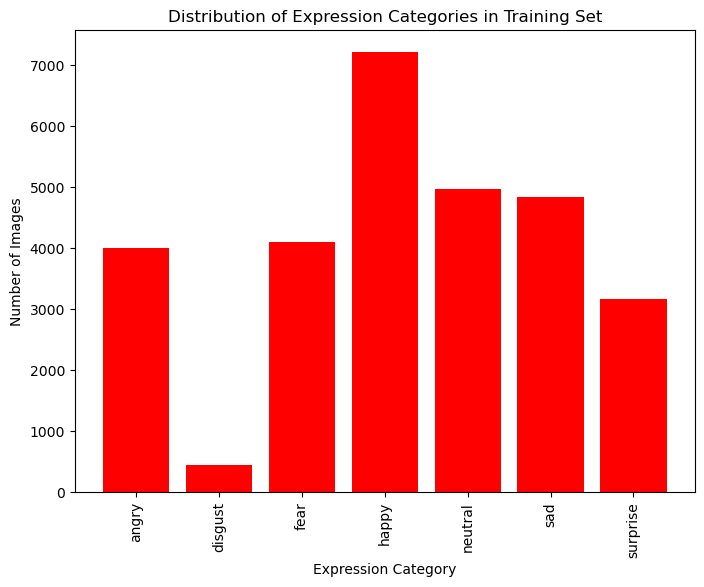

In [6]:
# Plot the distribution of expression categories in the sets
plt.figure(figsize=(8, 6))
plt.bar(train_image_counts.keys(), train_image_counts.values(), color='red')
plt.title("Distribution of Expression Categories in Training Set")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90);

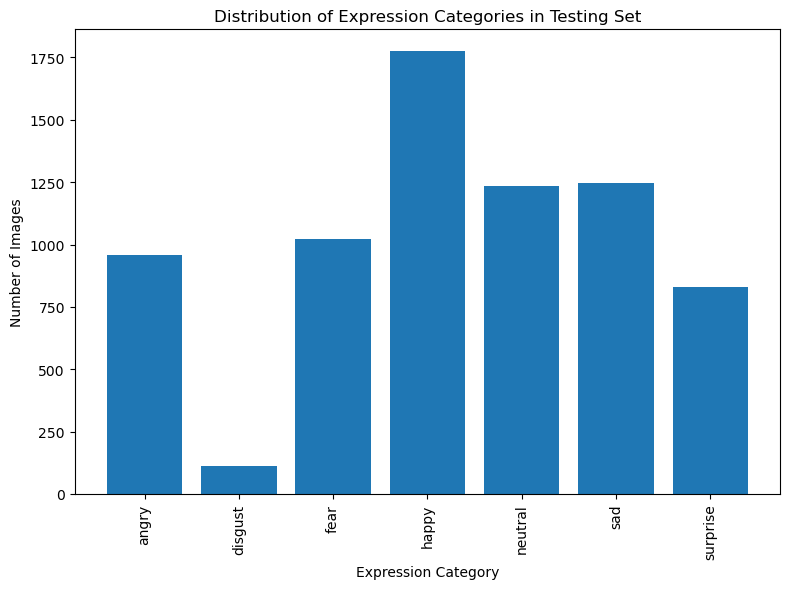

In [7]:
plt.figure(figsize=(8, 6))
plt.bar(test_image_counts.keys(), test_image_counts.values())
plt.title("Distribution of Expression Categories in Testing Set")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

In [8]:
def visualize_img_samples(directory, num_samples_per_category):
    
    # Get the expression categories from the training directory
    train_expressions = os.listdir(train_dir)
    
    # Create a figure with subplots for each expression category
    fig, axes = plt.subplots(nrows=len(train_expressions), ncols=num_samples_per_category, figsize=(10, 10))
    
    # Iterate over the expression categories
    for i, expr in enumerate(train_expressions):
        # Get the path to the expression directory
        expr_dir = os.path.join(train_dir, expr)
        
        # Get the image files in the expression directory
        expr_files = os.listdir(expr_dir)
        
        # Randomly select sample images
        sample_image_files = random.sample(expr_files, num_samples_per_category)
        
        # Display the sample images
        for j, sample_image_file in enumerate(sample_image_files):
            sample_image = cv2.imread(os.path.join(expr_dir, sample_image_file))
            axes[i, j].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(expr)
            axes[i, j].axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.001)
    
    # Display the figure
    plt.tight_layout()
    plt.show()

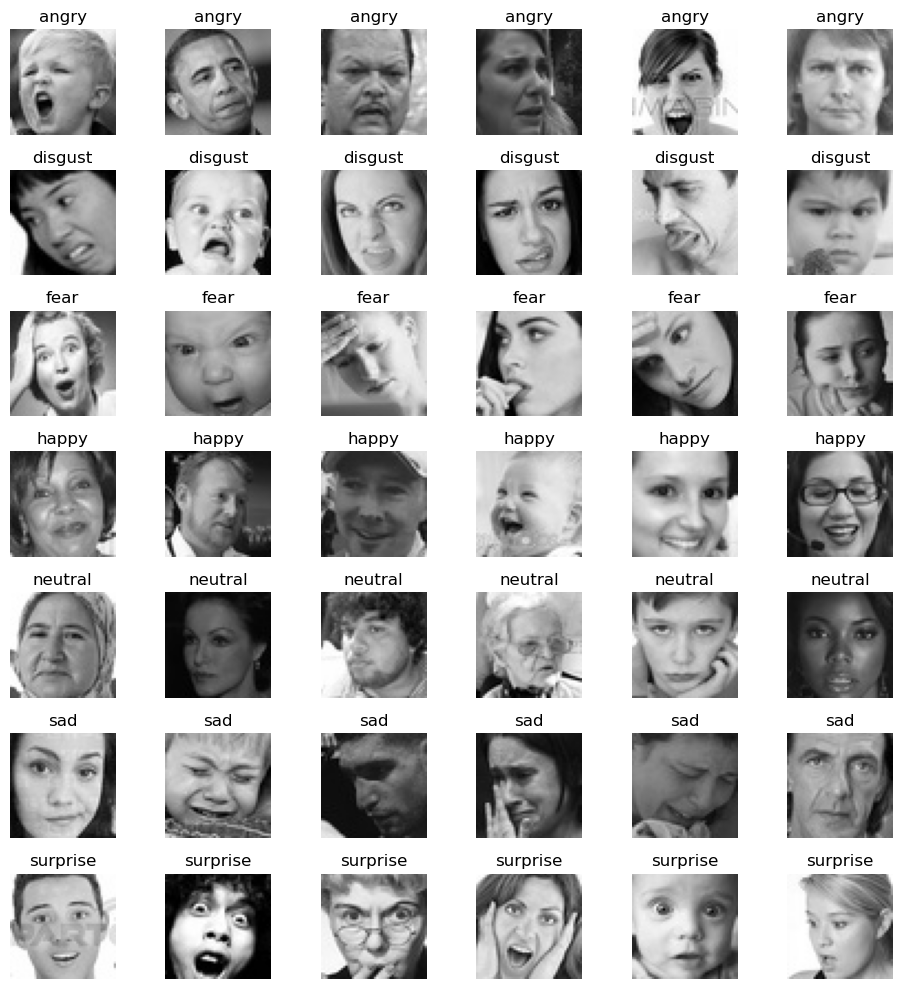

In [9]:
visualize_img_samples(train_dir, 6)

### 1.2 Findings

FER-2013 is an image contained dataset, all in 48x48 dimension where the faces were automatically registered, being centralized and categorized by emotions. There is an amount of 35,887 images, or faces, in this dataset and they are categorized by Angry (0), Disgust (1), Fear (2), Happy (3), Sad (4), Surprise (5) and Neutral (6). In these first steps we performed for the data understanding, two aspects strucked us; data imbalance and data accuracy.

For the first observations, it is clear that are imbalances in the dataset as the gap between the amount of images for the emotions Happy and Disgust is quite notable. 547 is the amount of images in the Disgust category and in contrast we find 8,989 images for the other category. There is as well a gap between Happy and the other remaining categories, which is not as big as the one just pointed, giving room for a possible balance in this amount what would may give less bias and overfitting to the future model, but as the first gap is quite large this balance might not be the best option. The best option is to train the model and see how it performs and with the results we are able to decide which way to go.

The accuracy aspect of the data comes when we sample a few random images from each of the emotions and could observe that not all of the images were accurate to their emotions. In some cases images/faces placed in the Happy category did not look to be a happy face, but a neutral, or a image place in the Fear category that does not resamble with the category. These are aspects that could change the accuracy of the model after the  training.

***

## 2. Data Preparation

### 2.1 Data Augmentation

In [5]:
# Define the preprocessing parameters for data augmentation
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1 / 255.,        # Rescale pixel values to [0, 1] range
    rotation_range = 15,       # Randomly rotate images by 0-20 degrees
    zoom_range = 0.1,          # Zoom to our object randomly
    horizontal_flip = True,    # Randomly flip images horizontally
    height_shift_range = 0.1,  # Shift the height of images by up to 10% randomly
    width_shift_range = 0.1,   # Shift the width of images by up to 10% randomly
    fill_mode = 'nearest',     # Replaces the empty area with the nearest pixel values
    validation_split = 0.2     # Set the validation split to 20%
)

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.  # Rescale pixel values to [0, 1] range
)

In [11]:
def visualize_augmentation(train_datagen, train_dir, num_samples=10):

    # Get the expression categories from the training directory
    expression_categories = os.listdir(train_dir)
    
    # Create a figure with subplots for each expression category
    fig, axes = plt.subplots(nrows=len(expression_categories), ncols=num_samples + 1, figsize=(10, 10))
    
    # Iterate over the expression categories
    for i, expr in enumerate(expression_categories):
        # Get the path to the expression directory
        expr_dir = os.path.join(train_dir, expr)
        
        # Get the image files in the expression directory
        expr_files = os.listdir(expr_dir)
        
        # Randomly select a sample image
        sample_image_file = random.choice(expr_files)
        sample_image = cv2.imread(os.path.join(expr_dir, sample_image_file))
        
        # Display the original sample image
        axes[i, 0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"Original ({expr})")
        axes[i, 0].axis('off')
        
        # Apply data augmentation and display the transformed images
        for j in range(1, num_samples + 1):
            # Apply data augmentation to the sample image
            augmented_image = train_datagen.random_transform(sample_image)
            
            # Display the transformed image
            axes[i, j].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(f"Augmented ({j})")
            axes[i, j].axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.001)
    
    # Display the figure
    plt.tight_layout()
    plt.show()

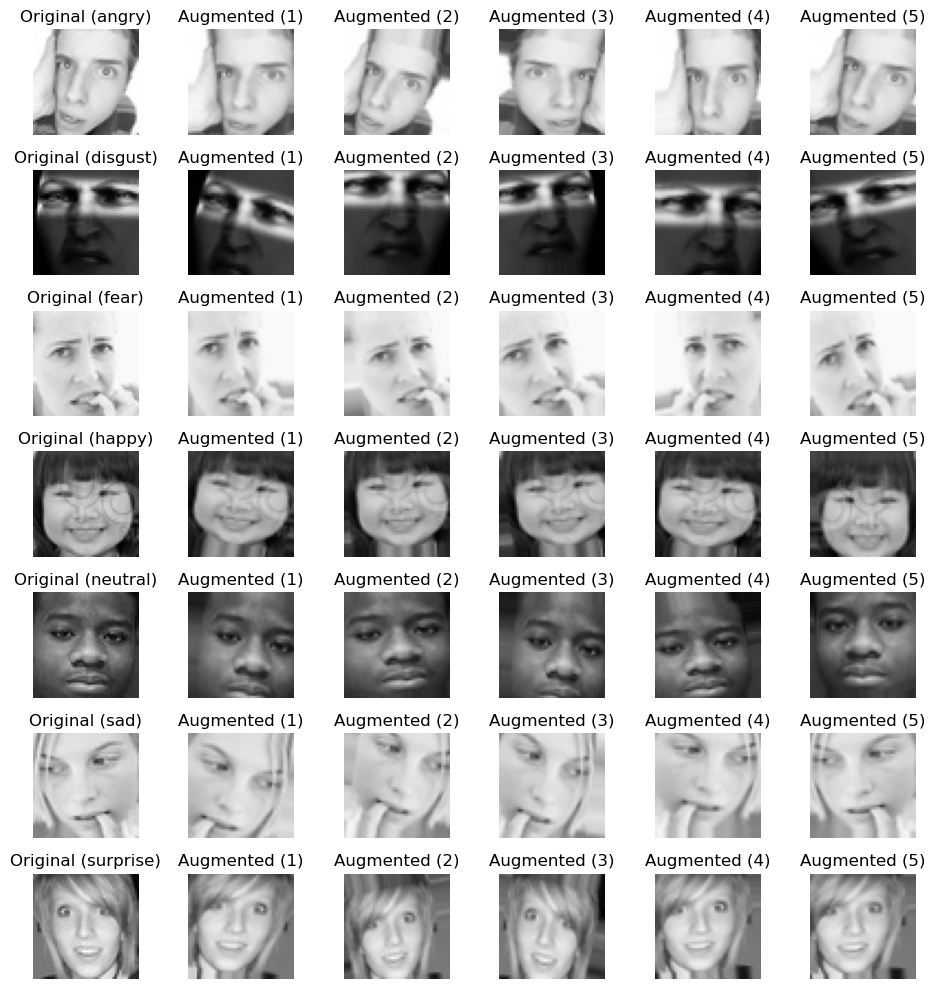

In [12]:
visualize_augmentation(train_datagen, train_dir, num_samples=5)

### 2.2 Preparing Training, Validation & Testing Sets with Keras Generators

In [6]:
# Specify the target size for images
img_size = 48

# Set the batch size for training
batch_size = 64

In [7]:
# Load the training data using flow_from_directory
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
print('Training Set: ', end = '')
train_generator = train_datagen.flow_from_directory(
    train_dir,                                # Path to the training image directory
    target_size = (img_size, img_size),       # Resize all images to target size
    batch_size = batch_size,                  # Number of images to be processed in each batch
    shuffle = True,                           # Shuffle the training data for each epoch
    class_mode='categorical',                 # Output labels will be one-hot encoded
    color_mode = 'rgb',                       # Load images in RGB color mode
    subset = 'training'                       # Use the training subset of the directory
)

# Load the validation data using flow_from_directory
print('Validation Set: ', end = '')
validation_generator = train_datagen.flow_from_directory(
    train_dir,                                # Path to the training image directory
    target_size = (img_size, img_size),       # Resize all images to target size
    batch_size = batch_size,                  # Number of images to be processed in each batch
    shuffle = False,                          # Do not shuffle the validation data
    class_mode='categorical',                 # Output labels will be one-hot encoded
    color_mode = 'rgb',                       # Load images in RGB color mode
    subset = 'validation'                     # Use the validation subset of the directory
)

# Load the testing data using flow_from_directory
print('Testing Set: ', end = '')
test_generator = test_datagen.flow_from_directory(
    test_dir,                                 # Path to the testing image directory
    target_size = (img_size, img_size),       # Resize all images to target size
    batch_size = batch_size,                  # Number of images to be processed in each batch
    shuffle = True,                           # Shuffle the testing data
    class_mode='categorical',                 # Output labels will be one-hot encoded
    color_mode = 'rgb',                       # Load images in RGB color mode
    subset = None                             # No subset for this directory
)

Training Set: Found 22968 images belonging to 7 classes.
Validation Set: Found 5741 images belonging to 7 classes.
Testing Set: Found 7178 images belonging to 7 classes.


---

## 3. Modeling

In [33]:
# Create the base pre-trained VGG16 model
# Source: https://keras.io/api/applications/vgg/
base_model = VGG16(input_shape=(img_size, img_size, 3), # Specify the input shape for the VGG16 model
                   include_top=False,                   # Exclude the top (classification) layer
                   pooling='avg',                       # Use global average pooling
                   weights="imagenet")                  # Load pre-trained weights from ImageNet

# Flatten the output from the base model
x = Flatten()(base_model.output)

# Add a dense layer with 7 units and softmax activation
x = Dense(7, activation='softmax')(x)

# Create the final model with the base model input and the new output layer
default = Model(base_model.input, x)

# Create an Adam optimizer instance with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model with the specified optimizer, loss function, and metrics
default.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Print a summary of the model architecture
default.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │              

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate a 3D visualization of the neural network model
visualkeras.layered_view(model, legend=True, scale_xy=1, scale_z=1, max_z=100)

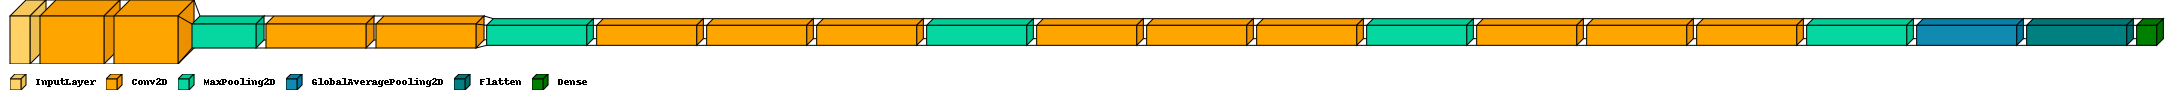

In [36]:
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning if the model loss does not decrease
# Source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',      # Monitor the validation loss
    factor = 0.5,              # Reduce the learning rate by a factor of 0.5
    patience = 10,             # Wait for 10 epochs before reducing the learning rate
    min_lr = 0.00001,          # Set a minimum learning rate of 0.00001
    verbose = 1                # Print a message when the learning rate is reduced
)

# Create Early Stopping Callback to monitor the accuracy
# Source: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(
    monitor = 'val_loss',         # Monitor the validation loss
    min_delta = 0.005,            # Minimum change in the monitored quantity to qualify as an improvement
    patience = 10,                # Wait for 10 epochs before stopping
    verbose = 1,                  # Print a message when the training is stopped
    restore_best_weights = True   # Restore the best model weights after stopping
)

# Combine the callbacks into a list
callbacks = [reduce_lr, early_stopping]

In [38]:
# Start model training
default_history = default.fit(
    train_generator,                          # Pass the training data generator
    validation_data = validation_generator,   # Pass the validation data generator
    epochs = 40,                              # Set the number of epochs to train for
    callbacks = callbacks,                    # Pass the list of callbacks
    verbose = 1                               # Set the verbosity level to 1 (print progress)
)

Epoch 1/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.2347 - loss: 1.8157 - val_accuracy: 0.2977 - val_loss: 1.7072 - learning_rate: 0.0010
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.2894 - loss: 1.6961 - val_accuracy: 0.3092 - val_loss: 1.6845 - learning_rate: 0.0010
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - accuracy: 0.2977 - loss: 1.6686 - val_accuracy: 0.3694 - val_loss: 1.5950 - learning_rate: 0.0010
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.3862 - loss: 1.5463 - val_accuracy: 0.4485 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 5/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.4698 - loss: 1.3787 - val_accuracy: 0.4745 - val_loss: 1.3304 - learning_rate: 0.0010
Epoch 6/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.4906 - loss: 1.3156 - val_accuracy: 0.5015 - val_loss: 1.2779 - learning_rate: 0.0010
Epoch 7/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.5173 - loss: 1.

### 3.1 Hyperparameter Tuning

For matters of computational power we had to split the tunning. The first try was made to check if keras.tuner would work for our model and the second try with more parameters and more computational power was to get the best hyperparameters.

#### 3.1.1 Test I

In [ ]:
# Define the hyperparameter search space
# Source: https://keras.io/keras_tuner/
def build_model(hp):
    # Load the base pre-trained VGG16 model
    base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, pooling='avg')
    
    # Flatten the output of the VGG16 model
    x = Flatten()(base_model.output)
    
    # Add a dense layer with 7 units and softmax activation for classification
    x = Dense(7, activation='softmax')(x)
    
    # Create the final model with the VGG16 input and the new output layer
    model = Model(base_model.input, x)

    # Define the hyperparameters to tune
    # Choose the learning rate from the values
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    # Choose the batch size from the values
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256])
    
    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Results:

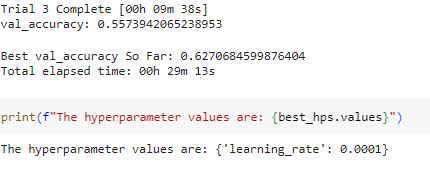

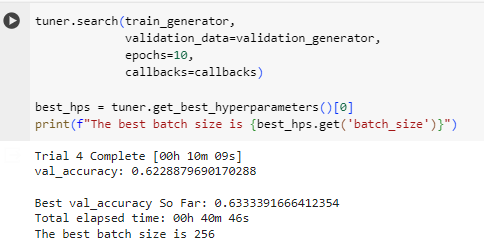

#### 3.1.2 Test 2

In [42]:
def build_model(hp):
    # Load the base pre-trained VGG16 model
    base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights="imagenet")

    x = GlobalAveragePooling2D()(base_model.output)

    # Add dense layers with varying number of units
    for i in range(hp.Int('num_layers', min_value=2, max_value=3)):
        units = hp.Choice(f'units_{i}', values=[256, 512, 1024, 2048, 4096])
        activation = hp.Choice(f'activation_{i}', values=["relu", "sigmoid"])
        x = Dense(units=units, activation=activation)(x)
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Add a dense layer with 7 units and softmax activation for classification
    x = Dense(7, activation='softmax')(x)

    # Create the final model with the VGG16 input and the new output layer
    tuner_model = Model(base_model.input, x)

    # Define the hyperparameters to tune
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    optimizer_params = {
        'adam': {
            'learning_rate': hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        },
        'sgd': {
            'learning_rate': hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        }
    }

    # Instantiate the optimizer with its corresponding parameters
    optimizer_name = optimizer
    if optimizer_name == 'adam':
        optimizer_object = tf.keras.optimizers.Adam(**optimizer_params['adam'])
    elif optimizer_name == 'sgd':
        optimizer_object = tf.keras.optimizers.SGD(**optimizer_params['sgd'])

    # Choose the batch size from the values
    batch_size = hp.Choice('batch_size', values=[128, 256])
    
    # Compile the model with the specified optimizer, loss function, and metrics
    tuner_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return tuner_model

In [43]:
# Instantiate the tuner
# Source: https://keras.io/keras_tuner/
tuner = kt.RandomSearch(
    build_model,             # The function that builds the model with hyperparameters
    objective='val_accuracy',  # The metric to optimize during tuning
    max_trials=5             # The maximum number of trial models to evaluate
)

In [ ]:
# Search for the best hyperparameters
# Source: https://keras.io/keras_tuner/
tuner.search(train_generator,                       # Pass the training data generator
             validation_data=validation_generator,  # Pass the validation data generator
             epochs=10)                             # Set the number of epochs to train for each trial

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

best_hyperparameters = best_hps.values

print("Best Hyperparameters:")
print(best_hyperparameters)

Trial 1 Complete [01h 16m 00s]
val_accuracy: 0.5880508422851562

Best val_accuracy So Far: 0.5880508422851562
Total elapsed time: 01h 16m 00s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
2                 |3                 |num_layers
512               |4096              |units_0
sigmoid           |relu              |activation_0
0.2               |0.3               |dropout_0
2048              |1024              |units_1
sigmoid           |relu              |activation_1
0.2               |0.1               |dropout_1
adam              |sgd               |optimizer
0.001             |0.0001            |learning_rate
256               |256               |batch_size
1024              |256               |units_2
sigmoid           |relu              |activation_2
0.4               |0.1               |dropout_2

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.1900 - loss: 1.9777 - val_accuracy: 0.1730 - val_loss: 1.8392
Epoch 2/10
359/

#### Best Hyperparameters found on GoogleColab

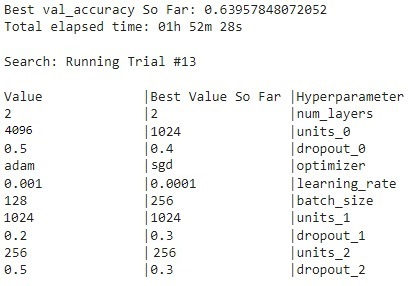

### 3.2 Final Custom Model

In [29]:
# Create the base pre-trained VGG16 model
# Source: https://keras.io/api/applications/vgg/
base_model = VGG16(input_shape=(img_size, img_size, 3),  # Specify the input shape for the VGG16 model
                   include_top=False,  # Exclude the top (classification) layer
                   weights="imagenet")

# Apply GlobalAveragePooling2D to the output of the base model
x = GlobalAveragePooling2D()(base_model.output)

# Create the additional dense layers
x = Dense(4096, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

# Add the final dense layer with 7 units and softmax activation
x = Dense(7, activation='softmax')(x)

# Create the final model with the base model input and the new output layers
final_custom_model = Model(base_model.input, x)

optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Compile the model with the specified optimizer, loss function, and metrics
final_custom_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Print a summary of the model architecture
final_custom_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │       2,101,2

 Total params: 21,018,439 (80.18 MB)

 Trainable params: 21,018,439 (80.18 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning if the model loss does not decrease
# Source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_accuracy',      # Monitor the validation accuracy
    factor = 0.5,              # Reduce the learning rate by a factor of 0.5
    patience = 5,             # Wait for 10 epochs before reducing the learning rate
    min_lr = 1e-7,          # Set a minimum learning rate of 1e-7
    verbose = 1                # Print a message when the learning rate is reduced
)

# Create Early Stopping Callback to monitor the accuracy
# Source: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',         # Monitor the valdation accuracy
    min_delta = 0.00005,              # Minimum change in the monitored quantity to qualify as an improvement
    patience = 11,                    # Wait for 10 epochs before stopping
    verbose = 1,                      # Print a message when the training is stopped
    restore_best_weights = True       # Restore the best model weights after stopping
)

# Combine the callbacks into a list
callbacks = [reduce_lr, early_stopping]

In [29]:
# Start model training
final_custom_history = final_custom_model.fit(
    train_generator,                                # Pass the training data generator
    validation_data=validation_generator,           # Pass the validation data generator
    batch_size=256,               # Use batch size from hyperparameters
    epochs=40,                                      # Set the number of epochs to train for
    callbacks=callbacks,                            # Pass the list of callbacks
    verbose=1                                       # Set the verbosity level to 1 (print progress)
)


Epoch 1/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.2463 - loss: 2.5845 - val_accuracy: 0.1552 - val_loss: 8.0496 - learning_rate: 1.0000e-04
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.3676 - loss: 1.8837 - val_accuracy: 0.3694 - val_loss: 2.0335 - learning_rate: 1.0000e-04
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.4367 - loss: 1.5706 - val_accuracy: 0.3748 - val_loss: 2.0740 - learning_rate: 1.0000e-04
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.4857 - loss: 1.4171 - val_accuracy: 0.5240 - val_loss: 1.3564 - learning_rate: 1.0000e-04
Epoch 5/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.5202 - loss: 1.3095 - val_accuracy: 0.5104 - val_loss: 1.3059 - learning_rate: 1.0000e-04
Epoch 6/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.5390 - loss: 1.2531 - val_accuracy: 0.4369 - val_loss: 1.4392 - learning_rate: 1.0000e-04
Epoch 7/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - acc

---

## 4. Evaluation

### 4.1 Performance Evaluation

#### Evaluation Default Model

In [40]:
# Compile the model with desired metrics
default.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the training set
train_loss, train_acc = default.evaluate(train_generator)

# Evaluate the model on the validation set
validation_loss, validation_acc = default.evaluate(validation_generator)

print("Training Accuracy:", train_acc)
print("Validation Accuracy:", validation_acc)

# Evaluate the model on the test set
test_loss, test_acc = default.evaluate(test_generator)
print("Test Accuracy:", test_acc)


359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.6688 - loss: 0.8881
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 376ms/step - accuracy: 0.5674 - loss: 1.1562
Training Accuracy: 0.6654911041259766
Validation Accuracy: 0.61017245054245
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 330ms/step - accuracy: 0.6228 - loss: 1.0105
Test Accuracy: 0.6193925738334656


#### Plot History Default Model

In [25]:
def plot_history(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

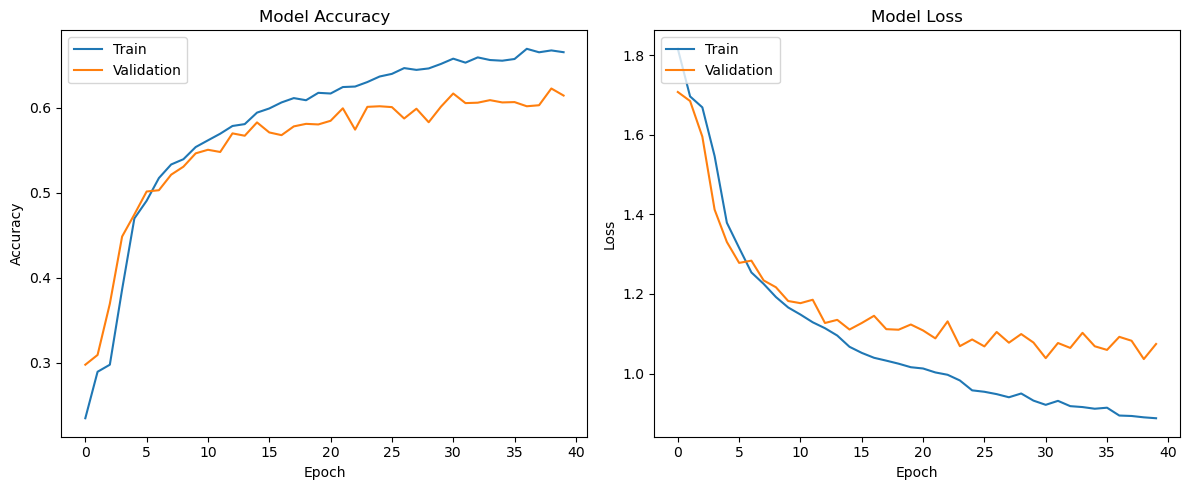

In [18]:
plot_history(default_history)

#### Classification Report and Confusion Matrix Default Model

In [35]:
# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Get the true labels and predicted labels for the validation set
y_true = validation_generator.classes
y_pred = default.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      0.50      0.44       799
     Disgust       0.00      0.00      0.00        87
        Fear       0.36      0.23      0.29       819
       Happy       0.70      0.87      0.78      1443
         Sad       0.51      0.57      0.54       993
    Surprise       0.42      0.32      0.36       966
     Neutral       0.69      0.64      0.66       634

    accuracy                           0.55      5741
   macro avg       0.44      0.45      0.44      5741
weighted avg       0.52      0.55      0.53      5741



C:\Users\diese\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\diese\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\diese\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 338ms/step


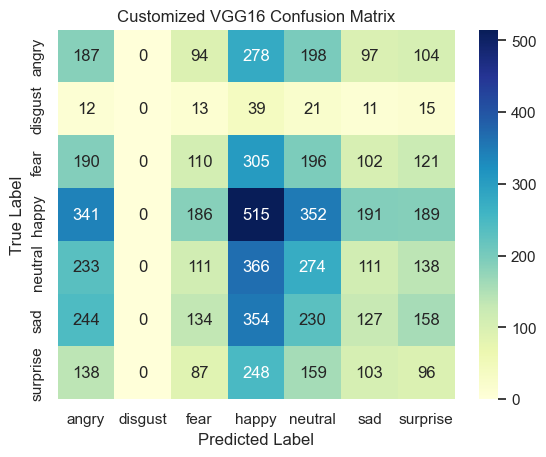

In [30]:
# Get the true labels from the test generator
true_labels = test_generator.classes

# Make predictions using the loaded model on the test set
predictions = default.predict(test_generator)

# Extract the predicted labels from the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
class_list = list(test_generator.class_indices.keys())  # Use the keys of class_indices to get the class list
cnf_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.set()
sns.heatmap(
    cnf_mtx,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    xticklabels=class_list,
    yticklabels=class_list
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Default VGG16 Confusion Matrix')
plt.show()


#### Evaluation Final Model

In [18]:
# Evaluate the model on the training set
train_loss, train_acc = final_custom_model.evaluate(train_generator)

# Evaluate the model on the validation set
test_loss, test_acc = final_custom_model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc * 100, test_acc * 100))

# Evaluate the model on the test set
test_loss, test_acc = final_custom_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

C:\Users\diese\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.9561 - loss: 0.1281
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.6220 - loss: 1.7608
final train accuracy = 95.37 , validation accuracy = 66.57
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.6777 - loss: 1.5000
Test accuracy: 67.11%


#### Plot History Final Custom Model

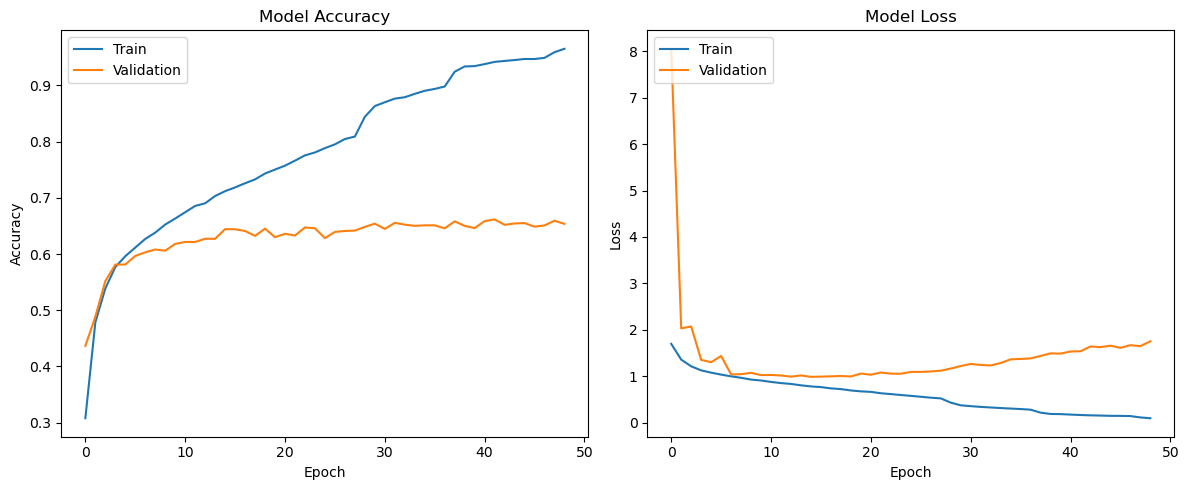

In [24]:
plot_history(final_custom_history)

#### Classification Report and Confusion Matrix Final Custom Model

In [24]:
# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Get the true labels and predicted labels for the validation set
y_true = validation_generator.classes
y_pred = final_custom_model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 339ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.57      0.57       799
     Disgust       0.76      0.64      0.70        87
        Fear       0.56      0.48      0.52       819
       Happy       0.86      0.83      0.85      1443
         Sad       0.58      0.66      0.62       993
    Surprise       0.53      0.55      0.54       966
     Neutral       0.79      0.81      0.80       634

    accuracy                           0.66      5741
   macro avg       0.67      0.65      0.66      5741
weighted avg       0.67      0.66      0.66      5741



113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step


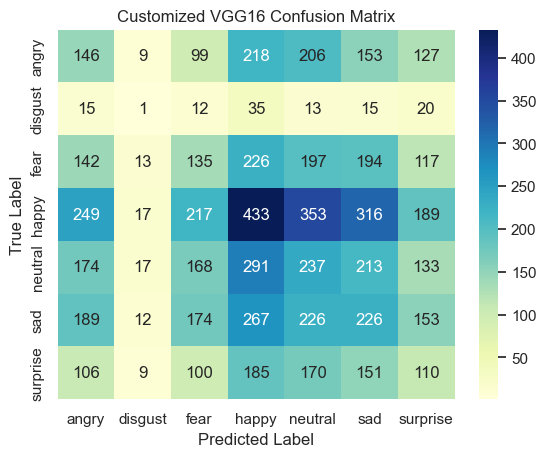

In [25]:
# Get the true labels from the test generator
true_labels = test_generator.classes

# Make predictions using the loaded model on the test set
predictions = final_custom_model.predict(test_generator)

# Extract the predicted labels from the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
class_list = list(test_generator.class_indices.keys())  # Use the keys of class_indices to get the class list
cnf_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.set()
sns.heatmap(
    cnf_mtx,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    xticklabels=class_list,
    yticklabels=class_list
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Customized VGG16 Confusion Matrix')
plt.show()


### 4.2. Performance Visualisation (True/False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


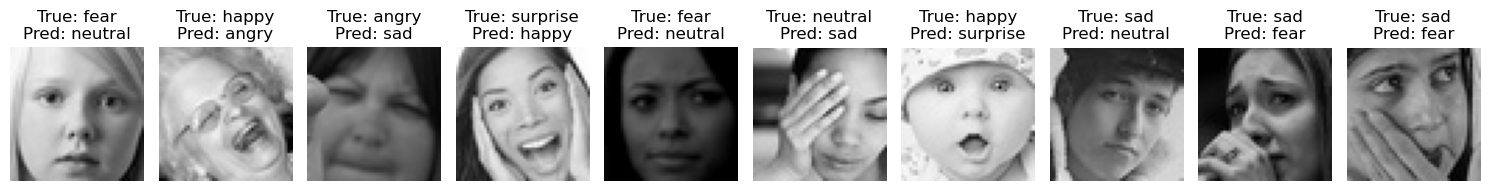

In [26]:
def visualize_misclassified_images(test_generator, model, class_indices, num_images=10):
    # Convert class indices to list of class labels
    class_labels = list(class_indices.keys())
    misclassified = []
    
    # Fetch batches from test_generator
    for images, true_labels in test_generator:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(true_labels, axis=1)
        
        # Iterate over images and labels
        for img, true, pred in zip(images, true_labels, pred_labels):
            if true != pred:
                misclassified.append((img, class_labels[true], class_labels[pred]))
            if len(misclassified) >= num_images:
                break
        
        # Break outer loop if we already have enough examples
        if len(misclassified) >= num_images:
            break

    # Plot misclassified images
    plt.figure(figsize=(15, 4))
    for i, (img, true_label, pred_label) in enumerate(misclassified[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified images
visualize_misclassified_images(test_generator, final_custom_model, class_indices=test_generator.class_indices)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


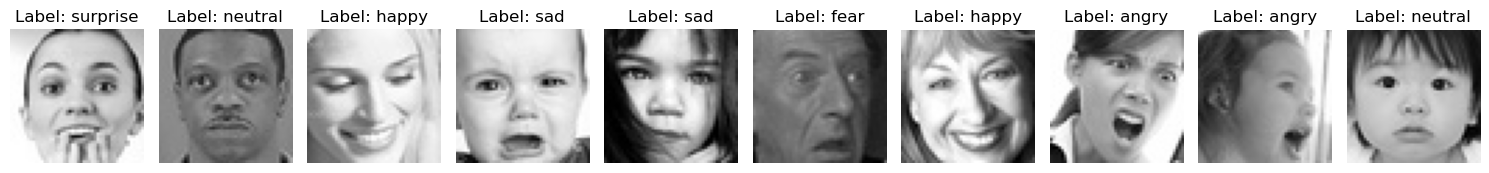

In [13]:
def visualize_correctly_classified_images(test_generator, model, class_indices, num_images=10):
    # Convert class indices to list of class labels
    class_labels = list(class_indices.keys())
    correctly_classified = []
    
    # Fetch batches from test_generator
    for images, true_labels in test_generator:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(true_labels, axis=1)
        
        # Iterate over images and labels
        for img, true, pred in zip(images, true_labels, pred_labels):
            if true == pred:
                correctly_classified.append((img, class_labels[true]))
            if len(correctly_classified) >= num_images:
                break
        
        # Break outer loop if we already have enough examples
        if len(correctly_classified) >= num_images:
            break

    # Plot correctly classified images
    plt.figure(figsize=(15, 4))
    for i, (img, label) in enumerate(correctly_classified[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to visualize correctly classified images
visualize_correctly_classified_images(test_generator, final_custom_model, class_indices=test_generator.class_indices)

### 4.3. Saliency Map

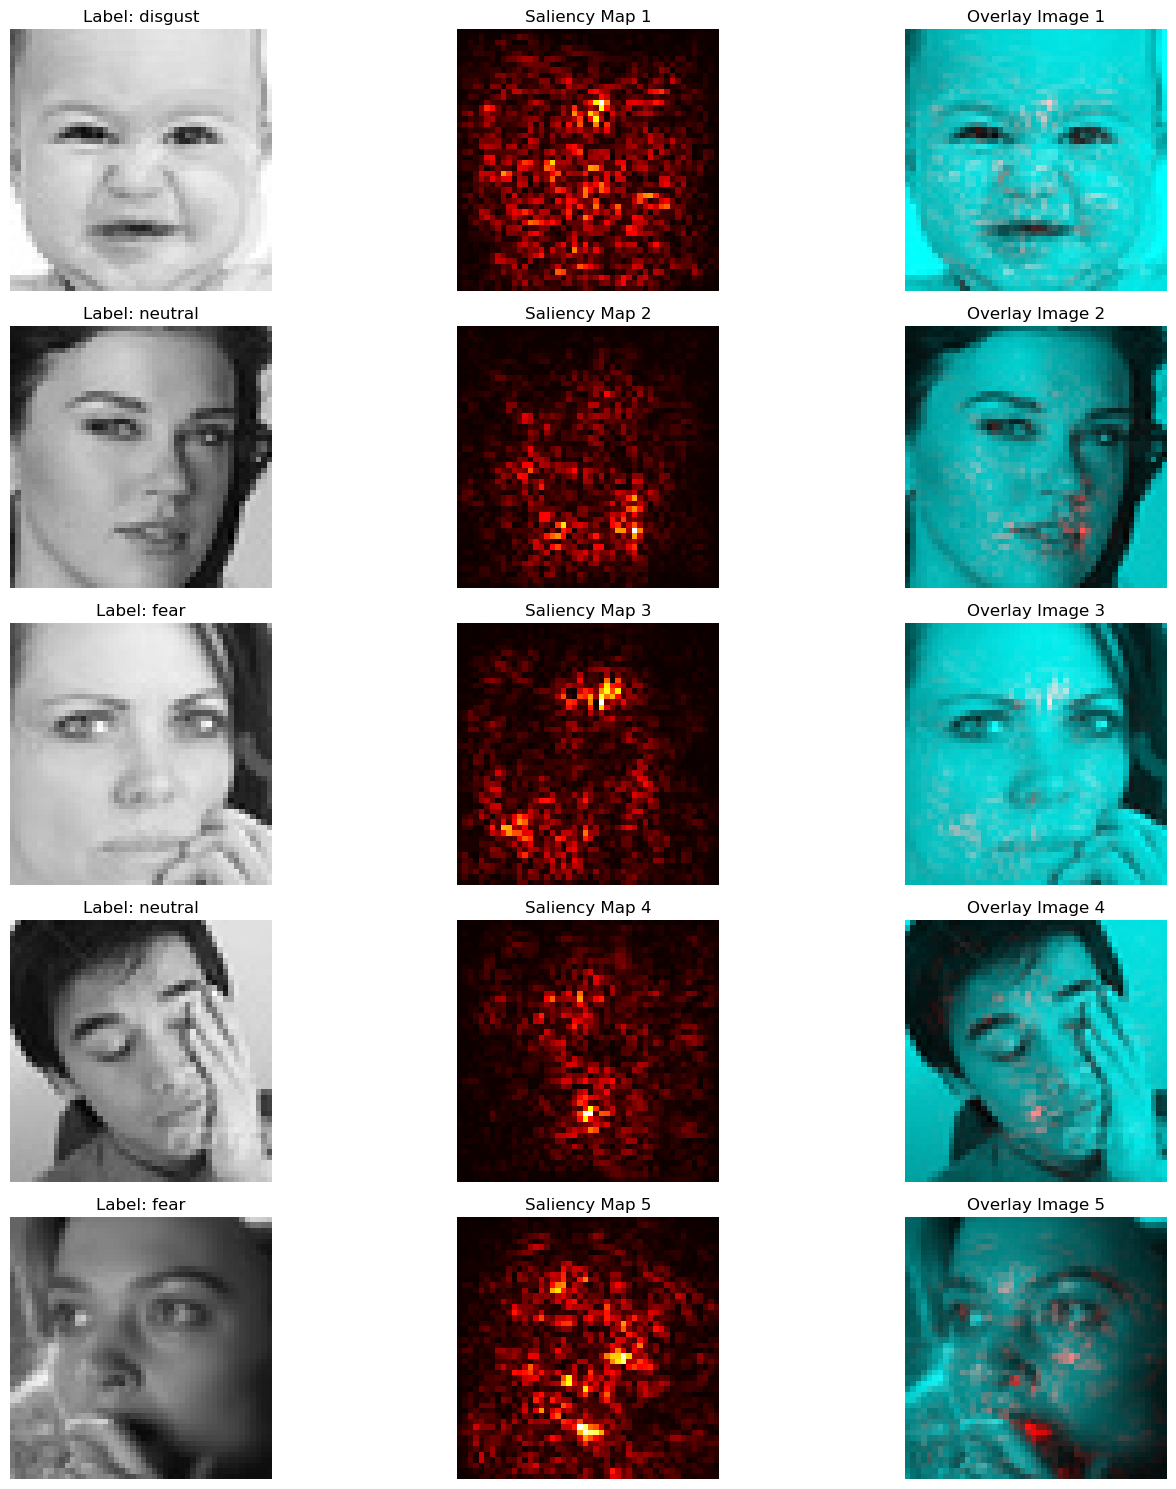

In [42]:
# Generate saliency map for an image
def generate_saliency_map(model, img):
    img_tensor = tf.expand_dims(img, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    saliency = tape.gradient(top_class_channel, img_tensor)
    saliency = tf.reduce_max(tf.abs(saliency), axis=-1).numpy()

    return saliency[0]

# Plot the images and their corresponding saliency maps
plt.figure(figsize=(15, 15))

# Number of images to visualize
num_images = 5

class_indices = test_generator.class_indices

for i in range(num_images):
    # Get a batch of images from the generator
    batch = next(test_generator)
    img = batch[0][0]  # Get the first image from the batch
    label_index = np.argmax(batch[1][0])  # Get the index of the label for the first image
    label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]  # Map index to class label

    saliency_map = generate_saliency_map(final_custom_model, img)
    
    # Plot original image
    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: {label}')

    # Plot saliency map
    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title(f'Saliency Map {i+1}')

    # Overlay saliency map onto original image
    overlay_img = np.zeros_like(img)
    overlay_img[:, :, 0] = saliency_map / np.max(saliency_map)  # Use saliency map as transparency mask
    overlay_img[:, :, 1] = img[:, :, 1]  # Green channel from original image
    overlay_img[:, :, 2] = img[:, :, 2]  # Blue channel from original image
    
    # Plot overlaid image
    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.title(f'Overlay Image {i+1}')

plt.tight_layout()
plt.show()


---

## 5. Deployment

In [66]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(cv2.resize(roi_gray, (48, 48)), axis=-1)
        cropped_img = np.repeat(cropped_img, 3, axis=-1)  # Repeat the grayscale channel 3 times
        cropped_img = np.expand_dims(cropped_img, axis=0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = final_custom_model.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
